In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from numba import types
from scipy.optimize import curve_fit
from tqdm import tqdm
from matplotlib.gridspec import GridSpec
from matplotlib import rcParams

COLOR = 'black'
plt.style.use("default")
rcParams["font.family"] = "serif"
rcParams["mathtext.fontset"] = "cm"
rcParams['figure.figsize'] = (28, 18)
rcParams['figure.titlesize'] = 20
rcParams['figure.dpi'] = 50
rcParams['axes.grid'] = True
rcParams['axes.facecolor'] = 'lightgray'
rcParams['legend.fontsize'] = 25
rcParams['axes.titlesize'] = 60
rcParams['axes.labelsize'] = 50
rcParams['ytick.labelsize'] = 20
rcParams['xtick.labelsize'] = 20
rcParams['text.color'] = COLOR
rcParams['text.color'] = COLOR
rcParams['axes.labelcolor'] = COLOR
rcParams['xtick.color'] = COLOR
rcParams['ytick.color'] = COLOR
rcParams['grid.color'] = COLOR
rcParams['text.latex.preamble'] = "\n".join([
    r'\usepackage[version=3]{mhchem}'
])

### Definiciones pre-simulación

In [2]:
#@njit #Para que numba compile la función
def h(S): #Calcula la energía de la red en   el estado S
    H = 0
    for i in np.arange(np.size(S,0)):
        for j in np.arange(np.size(S,1)):
            H += -S[ i ,j ]*(S[ i-1 , j ] + S[ i , j-1 ])/S.size
    return H
    #Aca S.size ya nos dá la normalización por L^2

#@njit
def calculate_dE(sij,i,j, S):
    # xx s3 xx
    # s4 s0 s2
    # xx s1 xx
    upper_i, upper_j = (i+1)%L, (j+1)%L #Si i+1 = L -> (i+1)%L=0, esto fuerza cc periódicas
    s1,s2,s3,s4 = S[i-1,j], S[i, upper_j ], S[ upper_i ,j], S[i,j-1]
    return -sij*(s1+s2+s3+s4) #El factor 2 tiene en cuenta la interacción i->j + j->i
    
#@njit
def metropolis(S, prob, N=0): #Aplica el algoritmo de Metropolis al estado S
    if N==S.size:
        return S,h(S), np.mean(S)
    i,j = np.random.choice(np.size(S,0),2) #Elegimos 2 posiciones al azar en el rango [0,L)
    sij = S[i,j] #Obtenemos el spin de esa posición
    opp_sij = -sij #Obtenemos el spin opuesto al original
    dE_sij = calculate_dE(opp_sij, i, j, S) - calculate_dE(sij, i, j, S) #La diferencia de energía entre tener el spin opuesto y tener el actual
    p = np.random.random(1)
    if dE_sij<=0:
        S[i,j] = opp_sij
    elif dE_sij==4:
        if p<prob[0]:
            S[i,j] = opp_sij
    elif dE_sij==8:
        if p<prob[1]:
            S[i,j] = opp_sij
    #La consigna dice que hay que aplicar el algoritmo de metrópolis por cada sitio en la red, es decir, L cuadrado veces.
    return metropolis(S,prob,N+1)


In [3]:
L = 30 #Dimensiones de la red
S=np.ones((L,L),dtype=int)
#S = 2*np.random.randint(2,size=(L,L))-1 #Red de -1y1 bidimensional
T = 2.27
beta = 1/T
dE = np.array([4, 8]) #únicos Delta_E positivos
prob = np.exp(-beta*dE)

Neq = 10_000 #Nro de pasos para el equilibrio
M = np.zeros(Neq) #Magnetización en función del paso
E = np.zeros(Neq) #Energía por particula en funcion del paso
M[0] = np.mean(S) #Promedio de spines
E[0] = h(S) # Energía por partícula


for n in tqdm(range(1,Neq)):
  S,E_new,M_new = metropolis(S,prob,0)
  M[n] = M_new
  E[n] = E_new

100%|██████████| 9999/9999 [02:42<00:00, 61.57it/s]


### Gráficos

Text(0.5, 1.0, '$\\beta = 0.441$')

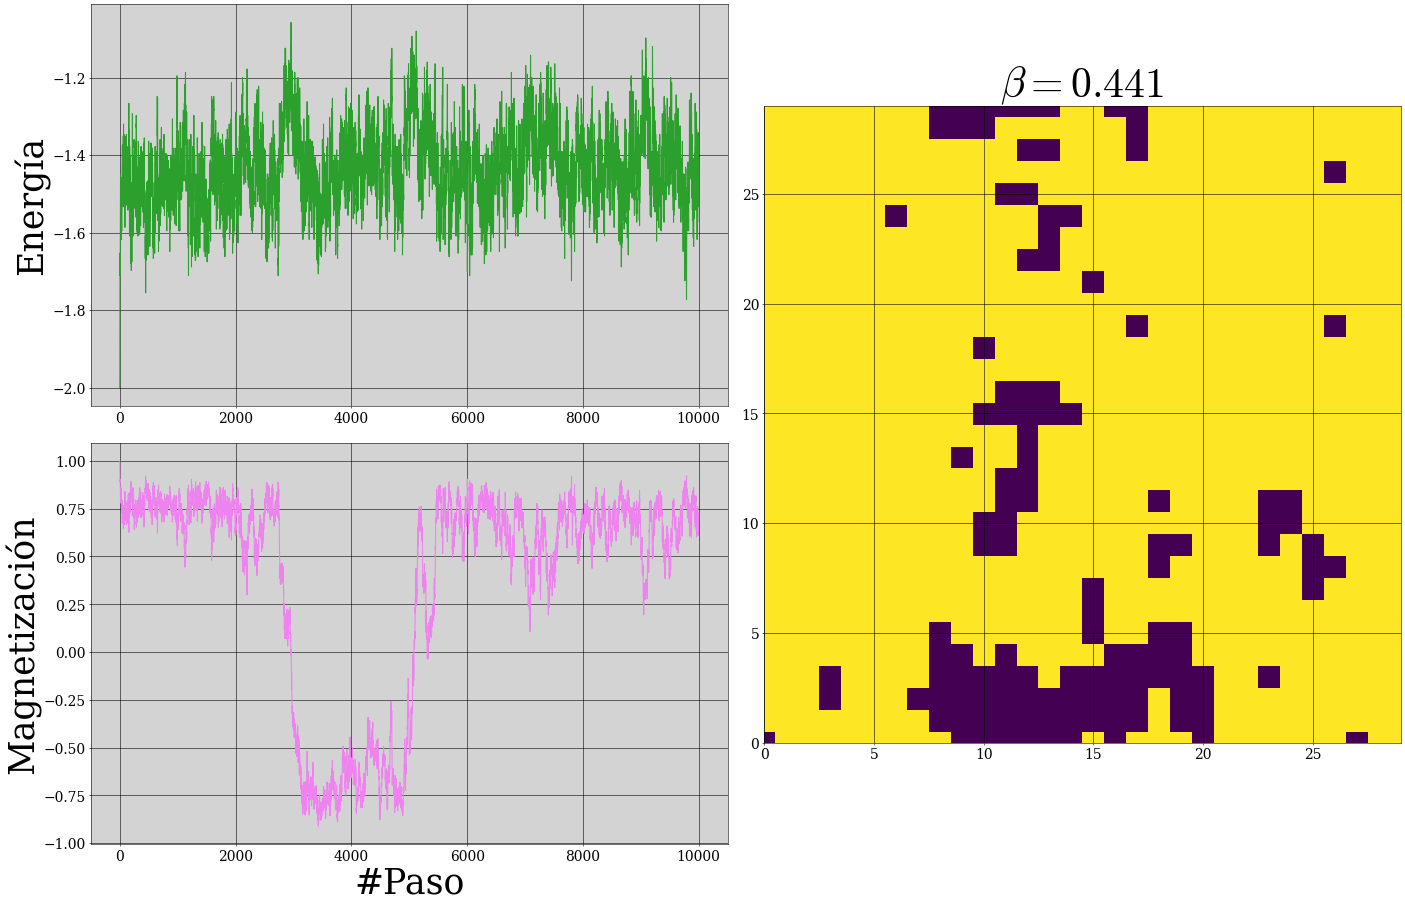

In [5]:
fig = plt.figure(layout='constrained')

gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[:,1])

ax1.plot(E, color='tab:green')
ax2.plot(M, color='violet')
ax3.imshow(S)

ax3.set_ylim(0,L-1)
ax3.set_xlim((0,L-1))


ax1.set_ylabel('Energía')
ax2.set_ylabel('Magnetización')
ax2.set_xlabel('#Paso')
ax3.set_title(f"$\\beta = {beta:.3g}$")